1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


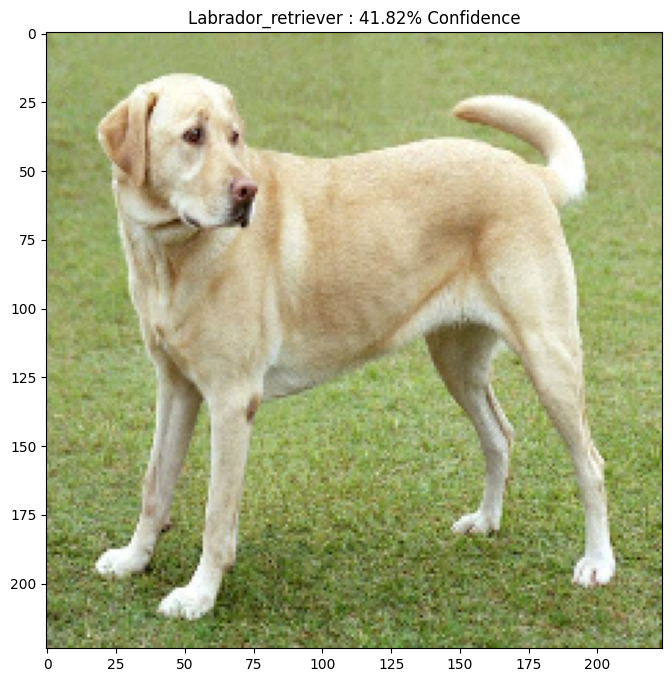

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


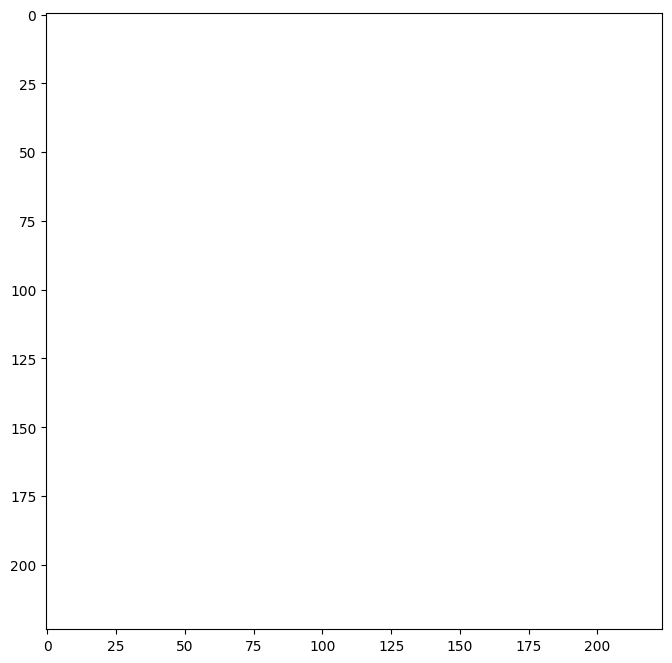

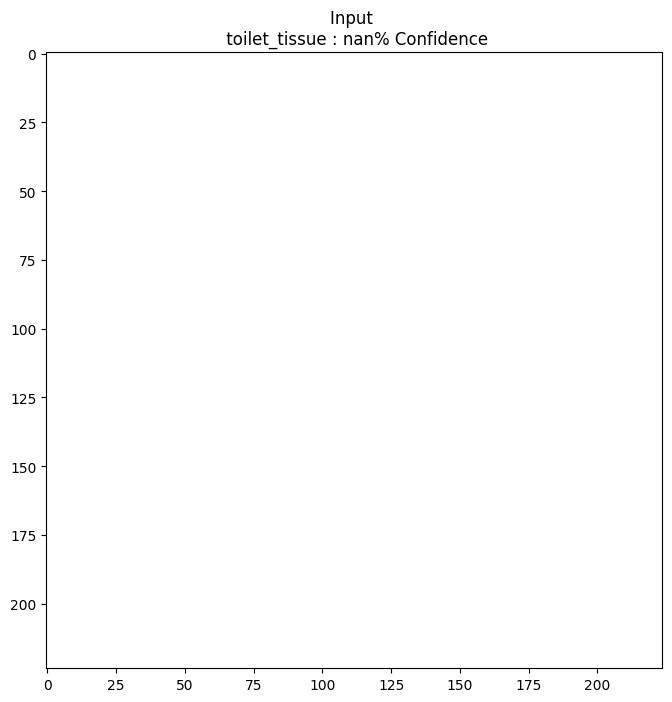

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


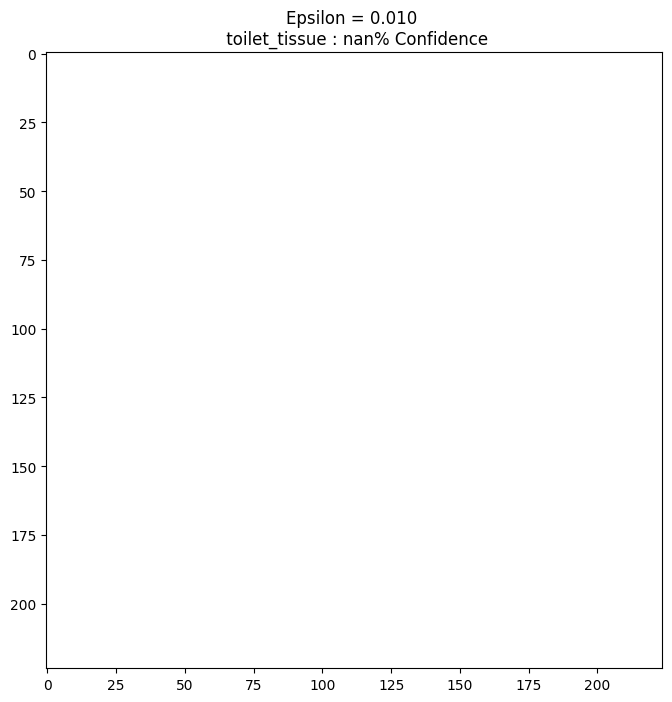

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


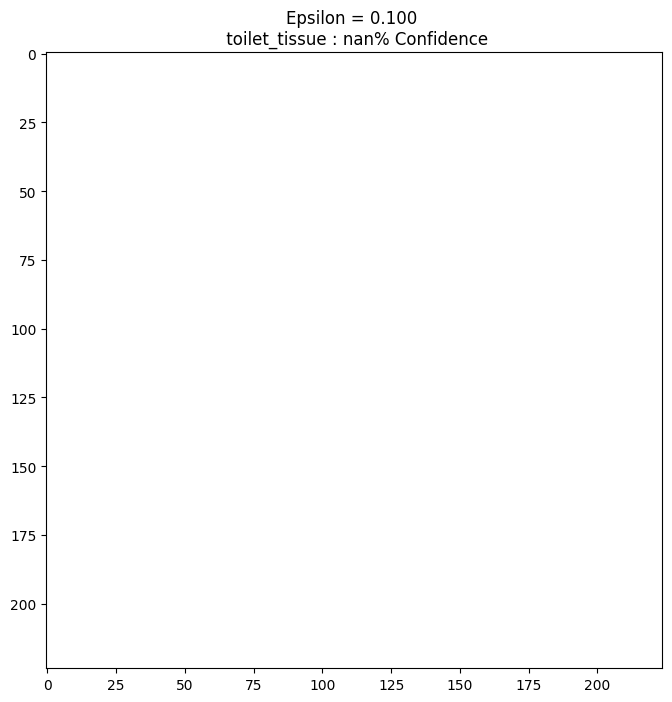

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


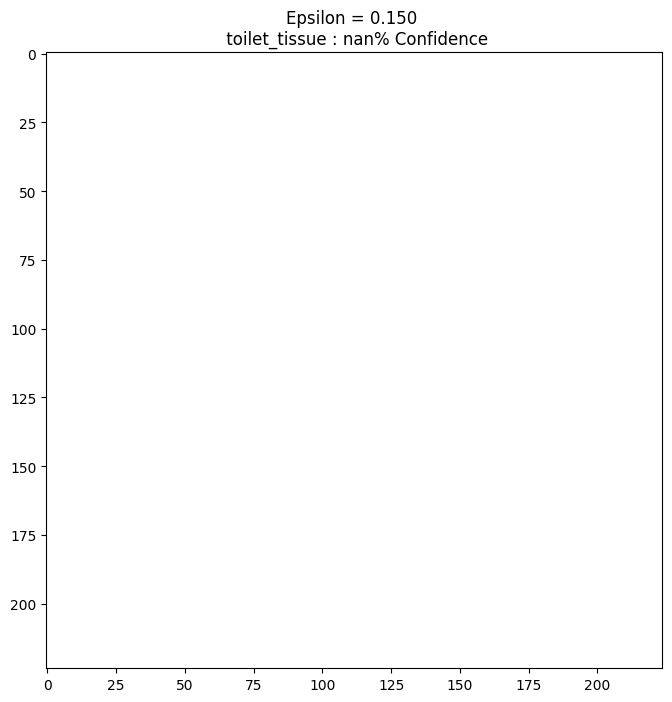

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
plt.imshow((image[0] + 1) / 2)  # Adjusting [-1, 1] to [0, 1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence * 100))
plt.show()

loss_object = tf.keras.losses.CategoricalCrossentropy()

def carlini_wagner_l2(model, images, labels, targeted=False, learning_rate=0.01, max_iterations=1000, confidence=0, initial_const=0.01):
    def cw_loss(logits, labels, targeted, confidence):
        real = tf.reduce_sum(labels * logits, axis=1)
        other = tf.reduce_max((1 - labels) * logits - labels * 1e4, axis=1)
        if targeted:
            return tf.maximum(other - real + confidence, 0)
        else:
            return tf.maximum(real - other + confidence, 0)

    def attack(images, labels):
        batch_size = tf.shape(images)[0]
        modifier = tf.Variable(tf.zeros_like(images), dtype=tf.float32)
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        
        for _ in range(max_iterations):
            with tf.GradientTape() as tape:
                adv_images = tf.tanh(modifier + images)
                logits = model(adv_images)
                loss = cw_loss(logits, labels, targeted, confidence) + initial_const * tf.reduce_sum(tf.square(adv_images - images))
            
            grads = tape.gradient(loss, [modifier])
            optimizer.apply_gradients(zip(grads, [modifier]))
        
        adv_images = tf.tanh(modifier + images)
        return adv_images

    images = tf.atanh((images - 0.5) * 1.999999)  # Inverse of tanh
    labels = tf.cast(labels, tf.float32)
    return attack(images, labels)

prediction = pretrained_model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))

perturbations = carlini_wagner_l2(pretrained_model, image, label)
perturbations = (perturbations - tf.reduce_min(perturbations)) / (tf.reduce_max(perturbations) - tf.reduce_min(perturbations))
plt.imshow(perturbations[0])

def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow((image[0] + 1) / 2)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(
        description, label, confidence * 100))
    plt.show()

epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])